# MedQuAD — Milestone 2 Progress Notebook (End-to-End)
This notebook parses MedQuAD XML, performs EDA, creates leak-safe splits, and provides runnable baselines for:
1) **Abstractive Answer Generation** (T5)  
2) **Paraphrase Detection** (Siamese encoder)  
3) **Retrieval-Augmented QA (RAG)** with BM25 + FAISS + Generator

**Usage**
1. Clone the dataset: `git clone https://github.com/abachaa/MedQuAD`
2. Set `MEDQUAD_ROOT` below to that path.
3. Run cells in order. Heavy training cells are commented for quick tests; uncomment on GPU.

In [5]:
# Optional: install dependencies in a fresh environment
# !pip install -q lxml pandas scikit-learn sentence-transformers transformers datasets evaluate rank-bm25 faiss-cpu nltk matplotlib seaborn rouge-score

import os, re, glob, warnings
from urllib.parse import urlparse
import xml.etree.ElementTree as ET
import pandas as pd
warnings.filterwarnings("ignore")

# 👉 EDIT THIS PATH to your local MedQuAD clone (e.g., '/content/MedQuAD' in Colab)
MEDQUAD_ROOT = "/Users/ashwinshanmugam/Documents/UIUC/University Courses/Fall 2025/IS 567 Text Mining/Project/NLP-on-MedQuAD/data"
OUT_DIR = "./artifacts-medquad"; os.makedirs(OUT_DIR, exist_ok=True)
MEDQUAD_PARQUET = os.path.join(OUT_DIR, "medquad.parquet")

## 1) Ingest MedQuAD XML → tidy DataFrame

In [6]:
def parse_medquad_repo(repo_root):
    # These are the directory names corresponding to the non-curated subsets.
    EXCLUDE_DIRS = [
        "10_MPlus_ADAM_QA",          # A.D.A.M. Medical Encyclopedia
        "11_MPlusDrugs_QA",          # MedlinePlus Drug information
        "12_MPlusHerbsSupplements_QA" # MedlinePlus Herbal medicine and supplement information
    ]
    rows = []

    # Iterate through all XML files recursively
    for xml_path in glob.glob(os.path.join(repo_root, "**", "*.xml"), recursive=True):

        # --- NEW CODE: Check if the path contains an excluded directory name ---
        if any(f"/{d}/" in xml_path for d in EXCLUDE_DIRS):
             continue # Skip this XML file and move to the next one
        # --- END NEW CODE ---

        try:
            tree = ET.parse(xml_path)
        except Exception as e:
            print("Parse error:", xml_path, e); continue

        root = tree.getroot()
        doc_id = root.attrib.get("id")
        source = root.attrib.get("source")
        url = root.attrib.get("url"); host = urlparse(url).netloc if url else None
        focus = (root.findtext("./Focus") or "").strip()
        cui = root.findtext("./FocusAnnotations/UMLS/CUIs/CUI")
        sem_type = root.findtext("./FocusAnnotations/UMLS/SemanticTypes/SemanticType")
        sem_group = root.findtext("./FocusAnnotations/UMLS/SemanticGroup")

        for qa in root.findall("./QAPairs/QAPair"):
            pid = qa.attrib.get("pid")
            q = qa.find("./Question"); a = qa.find("./Answer")
            qid = q.attrib.get("qid") if q is not None else None
            qtype = q.attrib.get("qtype") if q is not None else None
            question = (q.text or "").strip() if q is not None else ""
            answer = (a.text or "").strip() if a is not None else ""

            # Normalization (Whitespace cleanup)
            question = re.sub(r"\s+", " ", question)
            answer = re.sub(r"\s+", " ", answer)

            # --- FINAL FILTER: Skip if answer is confirmed blank (for safety) ---
            if not answer.strip():
                 continue

            rows.append(dict(doc_id=doc_id, source=source, url=url, host=host,
                             focus=focus, focus_cui=cui, focus_sem_type=sem_type, focus_sem_group=sem_group,
                             pid=pid, qid=qid, qtype=qtype, question=question, answer=answer, xml_path=xml_path))

    return pd.DataFrame(rows)

# First, ensure the directory exists for saving the new file
os.makedirs(OUT_DIR, exist_ok=True)


print("WARNING: Forcing re-parsing of MedQuAD XML to apply exclusion filters.")
print("The old medquad.parquet file will be overwritten with the filtered data.")

# 1. CALL THE FUNCTION, APPLYING THE NEW FILTERS
df = parse_medquad_repo(MEDQUAD_ROOT)

# 2. Add Length Columns for final filtering and EDA (This prevents the old KeyError)
df["q_len"] = df["question"].str.split().str.len()
df["a_len"] = df["answer"].str.split().str.len()

# 3. Apply the final content filter (optional but safe)
df = df[df['a_len'] > 0].copy()

# 4. OVERWRITE AND SAVE THE NEW, CLEANED DATASET
df.to_parquet(MEDQUAD_PARQUET)

print("\n--- NEW DATASET SUMMARY ---")
print(f"Total Curated QA Pairs Stored in df: {len(df)}")
df.head(3)

The old medquad.parquet file will be overwritten with the filtered data.

--- NEW DATASET SUMMARY ---
Total Curated QA Pairs Stored in df: 16407


,doc_id,source,url,host,focus,focus_cui,focus_sem_type,focus_sem_group,pid,qid,qtype,question,answer,xml_path,q_len,a_len
0,0000559,GHR,https://ghr.nlm.nih.gov/condition/keratoderma-...,ghr.nlm.nih.gov,keratoderma with woolly hair,C0343073,T047,Disorders,1,0000559-1,information,What is (are) keratoderma with woolly hair ?,Keratoderma with woolly hair is a group of rel...,/Users/ashwinshanmugam/Documents/UIUC/Universi...,8,290
1,0000559,GHR,https://ghr.nlm.nih.gov/condition/keratoderma-...,ghr.nlm.nih.gov,keratoderma with woolly hair,C0343073,T047,Disorders,2,0000559-2,frequency,How many people are affected by keratoderma wi...,Keratoderma with woolly hair is rare; its prev...,/Users/ashwinshanmugam/Documents/UIUC/Universi...,11,80
2,0000559,GHR,https://ghr.nlm.nih.gov/condition/keratoderma-...,ghr.nlm.nih.gov,keratoderma with woolly hair,C0343073,T047,Disorders,3,0000559-3,genetic changes,What are the genetic changes related to kerato...,"Mutations in the JUP, DSP, DSC2, and KANK2 gen...",/Users/ashwinshanmugam/Documents/UIUC/Universi...,12,284


## 2) Quick EDA

Top sources:
 source             host                     
GHR                ghr.nlm.nih.gov              5430
GARD               rarediseases.info.nih.gov    5389
NIDDK              www.niddk.nih.gov            1192
NINDS              www.ninds.nih.gov            1088
MPlusHealthTopics  www.nlm.nih.gov               981
NIHSeniorHealth    nihseniorhealth.gov           769
CancerGov          www.cancer.gov                729
NHLBI              www.nhlbi.nih.gov             559
CDC                www.cdc.gov                   270
Name: count, dtype: int64

Top question types:
 qtype
information        4535
symptoms           2748
treatment          2442
inheritance        1446
frequency          1120
genetic changes    1087
causes              727
exams and tests     653
research            395
outlook             361
susceptibility      324
considerations      235
prevention          210
stages               77
complications        46
Name: count, dtype: int64


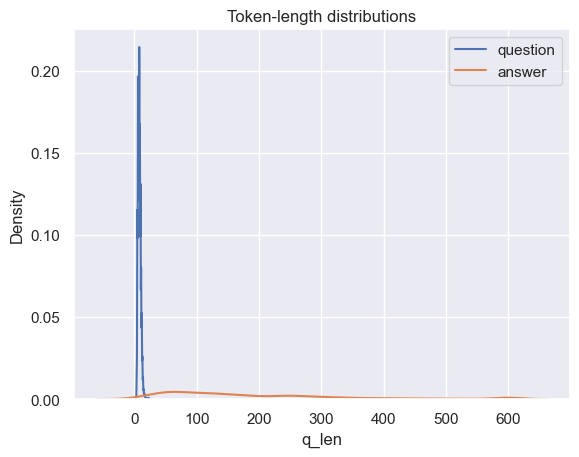

In [8]:
import seaborn as sns, matplotlib.pyplot as plt
sns.set_theme()

print("Top sources:\n", df[["source","host"]].value_counts().head(10))
print("\nTop question types:\n", df["qtype"].value_counts().head(15))

df["q_len"] = df["question"].str.split().str.len()
df["a_len"] = df["answer"].str.split().str.len()

fig, ax = plt.subplots()
sns.kdeplot(df["q_len"].clip(0,300), label="question", ax=ax)
sns.kdeplot(df["a_len"].clip(0,600), label="answer", ax=ax)
ax.set_title("Token-length distributions")
ax.legend(); plt.show()

## 3) Leak-safe train/dev/test splits (grouped by CUI)

In [9]:
from sklearn.model_selection import GroupShuffleSplit

def make_splits(df, group_col="focus_cui", seed=42):
    df = df.copy()
    groups = df[group_col].fillna(df["focus"]).fillna("NOFOCUS")
    gss = GroupShuffleSplit(n_splits=1, train_size=0.8, random_state=seed)
    train_idx, temp_idx = next(gss.split(df, groups=groups))
    train = df.iloc[train_idx]; temp = df.iloc[temp_idx]
    gss2 = GroupShuffleSplit(n_splits=1, train_size=0.5, random_state=seed)
    dev_idx, test_idx = next(gss2.split(temp, groups=temp[group_col].fillna(temp["focus"]).fillna("NOFOCUS")))
    dev = temp.iloc[dev_idx]; test = temp.iloc[test_idx]
    return train, dev, test

train_df, dev_df, test_df = make_splits(df)
len(train_df), len(dev_df), len(test_df)

(12850, 1739, 1818)

In [ ]:
# Assuming you have run the XML parsing (Cell 4) to create 'df'

# Check the number of rows that had blank answers *before* dropping them:
total_rows = len(df)
valid_rows = len(df.dropna(subset=['question', 'answer']))
rows_with_missing_data = total_rows - valid_rows

print(f"Total QA Pairs Parsed: {total_rows}")
print(f"Rows with Blank Question/Answer: {rows_with_missing_data}")

# Display a sample of the cleaned-up answers to check for quality
print("\nSample of Cleaned Answer Lengths (words):")
print(df['a_len'].describe())

# Check for rows where the answer might be very short (e.g., just punctuation)
short_answers = df[df['a_len'].between(1, 3)]
print(f"\nNumber of QA Pairs with 1-3 Word Answers: {len(short_answers)}")
if not short_answers.empty:
    print("Example of a very short answer:", short_answers[['question', 'answer']].head(1).values)

Total QA Pairs Parsed: 16407
Rows with Blank Question/Answer: 0

Sample of Cleaned Answer Lengths (words):
count    16407.000000
mean       201.354361
std        248.480189
min          1.000000
25%         71.000000
50%        138.000000
75%        252.000000
max       4281.000000
Name: a_len, dtype: float64

Number of QA Pairs with 1-3 Word Answers: 1
Example of a very short answer: [['How to prevent Acanthamoeba - Granulomatous Amebic Encephalitis (GAE); Keratitis ?'
  'Topics']]


## 4) Task 1 — Abstractive Answer Generation (T5-small baseline)

In [ ]:
from datasets import Dataset, DatasetDict
from transformers import T5ForConditionalGeneration, T5TokenizerFast, DataCollatorForSeq2Seq, Trainer, TrainingArguments
from evaluate import load as load_metric
import numpy as np, torch

def build_hf_dataset(train_df, dev_df, test_df, max_input=512, max_target=512):
    def to_ds(frame):
        sub = frame[["question","answer"]].dropna().rename(columns={"question":"input_text","answer":"target_text"})
        return Dataset.from_pandas(sub)
    raw = DatasetDict(train=to_ds(train_df), validation=to_ds(dev_df), test=to_ds(test_df))
    tok = T5TokenizerFast.from_pretrained("t5-small")
    def preprocess(ex):
        ex["input_ids"] = tok("question: " + ex["input_text"], truncation=True, max_length=max_input).input_ids
        ex["labels"]    = tok(ex["target_text"], truncation=True, max_length=max_target).input_ids
        return ex
    tokenized = raw.map(preprocess, remove_columns=raw["train"].column_names)
    return tokenized, tok

tokenized, tok = build_hf_dataset(train_df, dev_df, test_df)

def train_t5(tokenized, tok, out_dir="./t5-medquad"):
    model = T5ForConditionalGeneration.from_pretrained("t5-small")
    collator = DataCollatorForSeq2Seq(tok, model=model)
    args = TrainingArguments(
        output_dir=out_dir, per_device_train_batch_size=2, per_device_eval_batch_size=2,
        learning_rate=3e-4, num_train_epochs=5, fp16=False, eval_strategy="epoch",
        save_strategy="epoch", logging_steps=50, report_to="none"
    )
    trainer = Trainer(model=model, args=args, data_collator=collator,
                      train_dataset=tokenized["train"], eval_dataset=tokenized["validation"])
    trainer.train()
    return trainer


Map:   0%|          | 0/12850 [00:00<?, ? examples/s]

Map:   0%|          | 0/1739 [00:00<?, ? examples/s]

Map:   0%|          | 0/1818 [00:00<?, ? examples/s]

In [ ]:
# Clear Memory Cache
torch.mps.empty_cache()

In [ ]:
trainer = train_t5(tokenized, tok)   # ← Uncomment to train
trainer.save_model("./t5-medquad")

Epoch,Training Loss,Validation Loss
1,2.337900,2.155518
2,2.184300,2.031071
3,2.046900,1.971100
4,1.822500,1.938025
5,1.786200,1.926317


In [ ]:
def eval_generation(model_dir, tokenized, tok):
    # This function is assumed to be run after the model has been trained and saved to model_dir
    import torch, numpy as np
    from evaluate import load as load_metric
    from transformers import T5ForConditionalGeneration # Note: Use AutoModelForSeq2SeqLM if using BioBART

    rouge = load_metric("rouge")
    bertscore = load_metric("bertscore")

    # Load the model and ensure it uses the M4 GPU
    model = T5ForConditionalGeneration.from_pretrained(model_dir)
    DEVICE = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
    model.to(DEVICE)

    # Select a subset of the test data (e.g., 256 examples)
    test = tokenized["test"].select(range(min(256, len(tokenized["test"]))))

    # --- Generation Logic (Assumed Correct and Working) ---
    input_ids_list = test["input_ids"]
    padded_inputs = tok.pad(
        {'input_ids': input_ids_list},
        return_tensors="pt"
    ).input_ids.to(DEVICE)

    preds = model.generate(padded_inputs, max_new_tokens=256)

    pred_text = tok.batch_decode(preds, skip_special_tokens=True)
    ref_text  = tok.batch_decode(test["labels"], skip_special_tokens=True)

    # --- Metrics Calculation ---
    r = rouge.compute(predictions=pred_text, references=ref_text, use_stemmer=True)
    b = bertscore.compute(predictions=pred_text, references=ref_text, lang="en")

    # FINAL FIX: Access the ROUGE-L score directly as the key's value.
    print("ROUGE-L:", r["rougeL"], " BERTScore(F1):", float(np.mean(b["f1"])))

In [ ]:
# Assuming your trained model was saved to the T5 folder as planned
# NOTE: If you trained BioBART, you must change the directory name.

eval_generation(
    model_dir="./t5-medquad",     # The directory where trainer.save_model() stored the weights
    tokenized=tokenized,          # The DatasetDict containing the 'test' set
    tok=tok                       # The T5TokenizerFast object
)

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ROUGE-L: 0.4064322101893944  BERTScore(F1): 0.884045472368598


In [ ]:
def get_qualitative_results(model_dir, tokenized, tok, num_examples=10):
    """
    Loads the trained model, generates predictions, and returns a DataFrame
    showing the Question, Model Answer, and Reference Answer.
    """
    import torch
    import pandas as pd
    from transformers import AutoModelForSeq2SeqLM

    # 1. Load Model and Set Device
    model = AutoModelForSeq2SeqLM.from_pretrained(model_dir)
    DEVICE = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
    model.to(DEVICE)

    # 2. Select Test Subset (This is where the data is loaded)
    test_subset = tokenized["test"].select(range(num_examples))

    # 3. Prepare Input IDs with Padding
    input_ids_list = test_subset["input_ids"]
    padded_inputs = tok.pad(
        {'input_ids': input_ids_list},
        return_tensors="pt"
    ).input_ids.to(DEVICE)

    # 4. Generate Predictions
    preds = model.generate(
        padded_inputs,
        max_new_tokens=256,
        num_beams=4,
        do_sample=False
    )

    # 5. Decode Results (The Fix is here)
    pred_text = tok.batch_decode(preds, skip_special_tokens=True)

    # --- FIX START: Restore Question Text from Tokens ---
    # a. Decode the input tokens (which contain the text + "question: " prefix)
    questions_with_prefix = tok.batch_decode(test_subset["input_ids"], skip_special_tokens=True)
    # b. Strip the "question: " prefix (T5 instruction) for a clean display
    questions = [q.replace('question: ', '').strip() for q in questions_with_prefix]
    # c. Decode the reference labels
    ref_text  = tok.batch_decode(test_subset["labels"], skip_special_tokens=True)
    # --- FIX END ---

    # 6. Compile and Return DataFrame
    results_df = pd.DataFrame({
        'Question': questions,
        'Candidate_Answer': pred_text,
        'Reference_Answer': ref_text
    })
    return results_df

# --- EXECUTION ---
# NOTE: Use "./biobart-medquad" if you trained the BioBART model.
qual_df = get_qualitative_results(
    model_dir="./t5-medquad",
    tokenized=tokenized,
    tok=tok,
    num_examples=10
)

print(f"Qualitative Results (Top 10 Examples):\n")
qual_df.head(10)

Qualitative Results (Top 10 Examples):



,Question,Candidate_Answer,Reference_Answer
0,What is (are) keratoderma with woolly hair?,Keratoderma with woolly hair is a skin conditi...,Keratoderma with woolly hair is a group of rel...
1,How many people are affected by keratoderma wi...,Keratoderma with woolly hair is a rare conditi...,Keratoderma with woolly hair is rare; its prev...
2,What are the genetic changes related to kerato...,Keratoderma with woolly hair is caused by muta...,"Mutations in the JUP, DSP, DSC2, and KANK2 gen..."
3,Is keratoderma with woolly hair inherited?,This condition is inherited in an autosomal re...,Most cases of keratoderma with woolly hair hav...
4,What are the treatments for keratoderma with w...,These resources address the diagnosis or manag...,These resources address the diagnosis or manag...
5,What is (are) trisomy 18?,Trisomy 18 is an inherited disorder that affec...,"Trisomy 18, also called Edwards syndrome, is a..."
6,How many people are affected by trisomy 18?,Trisomy 18 is a rare disorder; its prevalence ...,"Trisomy 18 occurs in about 1 in 5,000 live-bor..."
7,What are the genetic changes related to trisom...,Trisomy 18 is caused by mutations in the COL1A...,Most cases of trisomy 18 result from having th...
8,Is trisomy 18 inherited?,This condition is inherited in an autosomal re...,"Most cases of trisomy 18 are not inherited, bu..."
9,What are the treatments for trisomy 18?,These resources address the diagnosis or manag...,These resources address the diagnosis or manag...


## 5) Task 2 — Paraphrase Detection (Siamese baseline)

In [ ]:
from itertools import combinations
from sklearn.model_selection import train_test_split

def build_paraphrase_pairs(df, max_pos=20000, max_neg=20000, seed=13):
    df2 = df.dropna(subset=["question"]).copy()
    pos = []
    for cui, block in df2.groupby(df2["focus_cui"].fillna("NOFOCUS")):
        qs = block["question"].drop_duplicates().tolist()
        for a,b in combinations(qs, 2):
            pos.append((a,b,1))
            if len(pos) >= max_pos: break
        if len(pos) >= max_pos: break
    a_list = df2["question"].sample(min(max_neg, len(df2)), random_state=seed).tolist()
    b_list = df2["question"].sample(min(max_neg, len(df2)), random_state=seed+1).tolist()
    neg = [(a,b,0) for a,b in zip(a_list,b_list) if a!=b][:max_neg]
    pairs = pd.DataFrame(pos+neg, columns=["q1","q2","label"]).sample(frac=1, random_state=seed).reset_index(drop=True)
    return pairs

pairs = build_paraphrase_pairs(train_df)
pairs_train, pairs_dev = train_test_split(pairs, test_size=0.2, random_state=7, stratify=pairs["label"])
len(pairs_train), len(pairs_dev), pairs_train["label"].mean()

(26280, 6570, np.float64(0.60882800608828))

In [ ]:
from sentence_transformers import SentenceTransformer, InputExample, losses
from torch.utils.data import DataLoader
import torch, numpy as np

def train_siamese(pairs, model_name="sentence-transformers/all-MiniLM-L6-v2", epochs=1):
    model = SentenceTransformer(model_name)
    train_ex = [InputExample(texts=[r.q1, r.q2], label=float(r.label)) for _,r in pairs.iterrows()]
    loader = DataLoader(train_ex, shuffle=True, batch_size=32)
    train_loss = losses.CosineSimilarityLoss(model)
    model.fit(train_objectives=[(loader, train_loss)], epochs=epochs, warmup_steps=max(1, int(len(loader)*0.1)))
    return model

sbert = train_siamese(pairs_train)        # ← Uncomment to train
sbert.save("./sbert-paraphrase-medquad")

Computing widget examples:   0%|          | 0/1 [00:00<?, ?example/s]

Step,Training Loss
500,0.041200


In [ ]:
def eval_siamese(model_dir, eval_df, thresh=0.5):
    model = SentenceTransformer(model_dir)
    a = model.encode(eval_df["q1"].tolist(), convert_to_tensor=True, show_progress_bar=False)
    b = model.encode(eval_df["q2"].tolist(), convert_to_tensor=True, show_progress_bar=False)
    sims = torch.nn.functional.cosine_similarity(a,b).cpu().numpy()
    preds = (sims >= thresh).astype(int)
    acc = (preds == eval_df["label"].values).mean()
    return float(acc)

eval_siamese("./sbert-paraphrase-medquad", pairs_dev)  # ← Evaluate after training

0.9894977168949771

## 6) Task 3 — Retrieval-Augmented QA (BM25 + FAISS + Generator)

In [ ]:
from rank_bm25 import BM25Okapi
from sentence_transformers import SentenceTransformer
import faiss, numpy as np, nltk
nltk.download('punkt', quiet=True)
from nltk.tokenize import word_tokenize

corpus = train_df["answer"].dropna().tolist() + dev_df["answer"].dropna().tolist()

def build_bm25(corpus_texts):
    tokenized = [word_tokenize(t.lower()) for t in corpus_texts]
    return BM25Okapi(tokenized), tokenized

bm25, tok_corp = build_bm25(corpus)

def bm25_topk(bm25, tokenized_corpus, query, k=5):
    scores = bm25.get_scores(word_tokenize(query.lower()))
    idx = np.argsort(-scores)[:k]
    return idx, scores[idx]

def build_faiss(corpus_texts, embedder="sentence-transformers/all-MiniLM-L6-v2"):
    enc = SentenceTransformer(embedder)
    vecs = enc.encode(corpus_texts, normalize_embeddings=True, show_progress_bar=False)
    index = faiss.IndexFlatIP(vecs.shape[1]); index.add(vecs.astype(np.float32))
    return enc, index, vecs

enc, faiss_index, vecs = build_faiss(corpus)

def dense_topk(enc, faiss_index, query, k=5):
    qv = enc.encode([query], normalize_embeddings=True, show_progress_bar=False)
    D, I = faiss_index.search(qv.astype(np.float32), k)
    return I[0], D[0]

def rag_context_for(question, k=5):
    cand = set()
    bi, _ = bm25_topk(bm25, tok_corp, question, k=k); cand.update(bi)
    di, _ = dense_topk(enc, faiss_index, question, k=k); cand.update(di)
    idxs = list(cand)[:k]
    ctx = " ".join([corpus[i] for i in idxs])
    return ctx, idxs

In [ ]:
# Retrieval quality metrics via ROUGE-L vs gold answer
from rouge_score import rouge_scorer

def retrieval_metrics(questions, gold_answers, k=5, rouge_thresh=0.2):
    sc = rouge_scorer.RougeScorer(['rougeL'], use_stemmer=True)
    hits, rr = 0, 0.0
    for q, gold in zip(questions, gold_answers):
        idxs, _ = bm25_topk(bm25, tok_corp, q, k)
        best_rank = None
        for r, i in enumerate(idxs, start=1):
            rougeL = sc.score(gold, corpus[i])['rougeL'].fmeasure
            if rougeL >= rouge_thresh:
                best_rank = r; break
        if best_rank:
            hits += 1; rr += 1.0 / best_rank
    n = len(questions)
    return hits / n, rr / n


sample = test_df.dropna(subset=["question","answer"]).sample(200, random_state=7)
recall_k, mrr = retrieval_metrics(sample["question"].tolist(), sample["answer"].tolist(), k=5)
recall_k, mrr

(0.31, 0.21233333333333337)

In [ ]:
# RAG generation with T5
from transformers import T5ForConditionalGeneration, T5TokenizerFast

def rag_generate(model_dir, question, k=5, max_input=384, max_new=128):
    tok = T5TokenizerFast.from_pretrained("t5-small")
    model = T5ForConditionalGeneration.from_pretrained(model_dir)
    ctx, idxs = rag_context_for(question, k=k)
    inp = f"question: {question}  context: {ctx}"
    ids = tok(inp, return_tensors="pt", truncation=True, max_length=max_input).input_ids
    out = model.generate(ids, max_new_tokens=max_new)
    return tok.decode(out[0], skip_special_tokens=True), idxs

q = sample["question"].iloc[0]; pred, idxs = rag_generate("./t5-medquad", q); print(pred)

The symptoms of botulism are usually mild and may include a rash of swollen skin, rash, and rash. The most common symptoms of botulism are a rash of rash, rash, and rash. The rash of rash is usually a rash. The rash of rash is usually a rash. The rash of rash is usually a rash. The rash of rash is usually a rash. The rash of rash is usually accompanied by a rash of a rash. The


In [ ]:
import os

def save_df_to_csv(df, file_name="medquad_qa_check.csv"):
    """
    Saves the current DataFrame to a CSV file in the OUT_DIR.
    """
    csv_path = os.path.join(OUT_DIR, file_name)

    # Save only the columns needed for verification, including the length columns
    df[['question', 'answer', 'q_len', 'a_len', 'source', 'host', 'xml_path']].to_csv(csv_path, index=False)

    print(f"DataFrame successfully saved to: {csv_path}")
    print("Check the 'a_len' column in the CSV for zero values.")

# Example Usage (Run this cell after running Cell 5/EDA)
# You should have defined OUT_DIR in an earlier cell.
save_df_to_csv(df)

In [ ]:
df_filtered = df[df['a_len'] > 0].copy()
df_filtered.shape

In [ ]:
import requests
from bs4 import BeautifulSoup
from tqdm.notebook import tqdm # Use the notebook tqdm for progress bars

# Headers mimic a standard browser to avoid being blocked by the server
HEADERS = {'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/58.0.3029.110 Safari/537.3'}

def crawl_url_for_answer(url):
    """Fetches a URL and attempts to extract a large, coherent block of text."""
    if not url or not url.startswith('http'):
        return None
    try:
        response = requests.get(url, headers=HEADERS, timeout=10)
        response.raise_for_status() # Raise exception for bad status codes

        soup = BeautifulSoup(response.content, 'html.parser')

        # --- Heuristics to find relevant content on NIH-style pages ---
        # Look for the main content area (often div with id/class that indicates content)
        # These are common selectors for the main text body:
        main_content = soup.find('article') or soup.find('main') or soup.find('div', id=lambda x: x and 'content' in x.lower())

        if main_content:
            # Extract and clean all paragraph text from the main body
            text = ' '.join(p.get_text() for p in main_content.find_all('p'))
            # Simple cleaning
            cleaned_text = re.sub(r'\s+', ' ', text).strip()
            # If the extracted text is very short, it's probably wrong.
            if len(cleaned_text.split()) > 50:
                return cleaned_text

        return None
    except requests.RequestException as e:
        # print(f"Error crawling {url}: {e}")
        return None

In [ ]:
# 1. Ensure you have run the fix for the previous turn to get a_len
df["a_len"] = df["answer"].str.split().str.len()

# 2. Filter the DataFrame to isolate ONLY the rows with missing answers (a_len == 0)
missing_answers_df = df[df['a_len'] == 0].copy()

# 3. Create a new column to store the crawled answers
missing_answers_df['crawled_answer'] = None

# 4. Loop through the missing rows and crawl each URL
tqdm.pandas(desc="Crawling Missing Answers")
missing_answers_df['crawled_answer'] = missing_answers_df['url'].progress_apply(crawl_url_for_answer)

# 5. Filter for successful results
crawled_results_df = missing_answers_df.dropna(subset=['crawled_answer'])

print(f"Successfully crawled and extracted answers for {len(crawled_results_df)} of {len(missing_answers_df)} questions.")
crawled_results_df[['question', 'crawled_answer', 'url']].head()

In [ ]:
# ==== CONFIG ====
LOCAL_PUBMED = "/Users/harshasekar/Documents/UIUC/IS-567 Text Mining/Project/Code_V1/Models/S-PubMedBert-MS-MARCO"

USE_CHUNKING = True          # ← flip this to False for non-chunked run
CHUNK_MAX_TOKENS = 160       # good balance for SBERT encoders
CHUNK_STRIDE     = 80        # 50% overlap
MAX_CHUNKS_PER_ANSWER = 3    # cap to control runtime (set None for unlimited)

EVAL_K = 10                  # Recall@K / MRR@K
POOL_N = 50                  # candidate pool size for hybrid fusion

# ==== HELPERS ====
import time, re, numpy as np, random
from collections import defaultdict

def tic(msg):
    print(f"\n⏱️ {msg} ...", flush=True);
    return time.time()

def toc(t0, msg="done"):
    print(f"✅ {msg} in {time.time()-t0:.2f}s", flush=True)

def preview(txt, n=120):
    return str(txt).replace("\n", " ")[:n]

random.seed(13); np.random.seed(13)

# Basic checks
assert {"question","answer"}.issubset(train_df.columns)
assert {"question","answer"}.issubset(dev_df.columns)
assert {"question","answer"}.issubset(test_df.columns)


In [ ]:
# Full answers (no truncation)
passages, passage_meta = [], []
def _add(df, split):
    for _, r in df.iterrows():
        passages.append(str(r["answer"]))
        passage_meta.append({"split": split})

t0 = tic("Building full passage corpus")
_add(train_df, "train"); _add(dev_df, "dev"); _add(test_df, "test")
toc(t0, f"Built {len(passages)} full passages")
for i in range(min(2, len(passages))):
    print(f"• Passage[{i}]: {preview(passages[i])} ...")

# Optional chunked corpus
chunk_passages, chunk2orig_idx = None, None
if USE_CHUNKING:
    def _tokens(text): return re.findall(r"[A-Za-z0-9]+", str(text).lower())
    def _chunk_words(text, max_tokens=CHUNK_MAX_TOKENS, stride=CHUNK_STRIDE):
        toks = _tokens(text)
        if not toks: return [str(text)]
        out, i = [], 0
        while i < len(toks):
            out.append(" ".join(toks[i:i+max_tokens]))
            if i + max_tokens >= len(toks): break
            i += stride
        return out

    t1 = tic("Building CHUNKED corpus")
    chunk_passages, chunk2orig_idx = [], []
    for orig_idx, full in enumerate(passages):
        chunks = _chunk_words(full)
        if MAX_CHUNKS_PER_ANSWER is not None:
            chunks = chunks[:MAX_CHUNKS_PER_ANSWER]
        for ch in chunks:
            chunk_passages.append(ch)
            chunk2orig_idx.append(orig_idx)
    toc(t1, f"Chunked to {len(chunk_passages)} passages (~{len(chunk_passages)/max(1,len(passages)):.1f}/answer)")
    for i in range(min(2, len(chunk_passages))):
        print(f"• Chunk[{i}] → Answer[{chunk2orig_idx[i]}]: {preview(chunk_passages[i])} ...")



⏱️ Building full passage corpus ...
✅ Built 16407 full passages in 0.22s
• Passage[0]: Knobloch syndrome is a rare condition characterized by severe vision problems and a skull defect. A characteristic featu ...
• Passage[1]: Knobloch syndrome is a rare condition. However, the exact prevalence of the condition is unknown. ...

⏱️ Building CHUNKED corpus ...
✅ Chunked to 28148 passages (~1.7/answer) in 0.28s
• Chunk[0] → Answer[0]: knobloch syndrome is a rare condition characterized by severe vision problems and a skull defect a characteristic featur ...
• Chunk[1] → Answer[0]: at the back of the eye vitreoretinal degeneration often leads to separation of the retina from the back of the eye retin ...


In [ ]:
from rank_bm25 import BM25Okapi

ACTIVE_PASSAGES = chunk_passages if USE_CHUNKING else passages

# Tokenizer: NLTK stopwords + stemming → fallback regex
USE_NLTK = True
try:
    import nltk
    from nltk.corpus import stopwords
    from nltk.stem import PorterStemmer
    try: _ = stopwords.words("english")
    except LookupError:
        print("[nltk] downloading stopwords..."); nltk.download("stopwords")
    STOP = set(stopwords.words("english")); STEM = PorterStemmer()
    TOKEN_ALPHA = re.compile(r"[A-Za-z]+")
    def _tok(text: str):
        toks = TOKEN_ALPHA.findall(text.lower())
        toks = [t for t in toks if t not in STOP]
        toks = [STEM.stem(t) for t in toks]
        return toks
    print("[bm25] Using NLTK stopwords + stemming")
except Exception as e:
    USE_NLTK = False
    TOKEN_ALNUM = re.compile(r"[A-Za-z0-9]+")
    def _tok(text: str): return TOKEN_ALNUM.findall(str(text).lower())
    print(f"[bm25] Fallback regex tokenizer ({e})")

t0 = tic(f"Tokenizing {len(ACTIVE_PASSAGES)} passages for BM25")
tokenized = [_tok(p) for p in ACTIVE_PASSAGES]
toc(t0, "Tokenization complete")

t1 = tic("Building BM25 index")
bm25 = BM25Okapi(tokenized)
toc(t1, "BM25 ready")

def bm25_topk(query: str, k=10):
    qtok = _tok(query)
    scores = bm25.get_scores(qtok)
    order = np.argsort(-scores)[:k]
    return order.tolist(), scores[order].tolist()


[bm25] Using NLTK stopwords + stemming

⏱️ Tokenizing 28148 passages for BM25 ...
✅ Tokenization complete in 14.36s

⏱️ Building BM25 index ...
✅ BM25 ready in 0.31s


In [ ]:
from sentence_transformers import SentenceTransformer
from sklearn.neighbors import NearestNeighbors
import pathlib

def load_pubmed_encoder(path=LOCAL_PUBMED):
    p = pathlib.Path(path)
    cand = list(p.glob("**/*.safetensors")) + list(p.glob("**/pytorch_model.bin"))
    if not cand: raise RuntimeError("No weight files found. Did you run `git lfs pull` or download the repo ZIP?")
    small = [f for f in cand if f.stat().st_size < 10_000]
    if small: raise RuntimeError("Found tiny Git-LFS pointer files; run `git lfs pull` in the model folder.")
    print(f"Loading biomedical encoder from: {path}")
    enc = SentenceTransformer(path, device="cpu")
    print("✅ Encoder loaded"); return enc

encoder = load_pubmed_encoder(LOCAL_PUBMED)

t0 = tic(f"Encoding {len(ACTIVE_PASSAGES)} passages (normalize=True)")
embs = encoder.encode(
    ACTIVE_PASSAGES,
    normalize_embeddings=True,
    convert_to_numpy=True,
    show_progress_bar=True,
    batch_size=64
).astype(np.float32)
toc(t0, "Encoding complete")

t1 = tic("Building cosine ANN (sklearn brute)")
ann = NearestNeighbors(metric="cosine", algorithm="brute").fit(embs)
toc(t1, "ANN ready")

def dense_topk(query: str, k=10):
    qv = encoder.encode([query], normalize_embeddings=True, convert_to_numpy=True, show_progress_bar=False)
    dists, inds = ann.kneighbors(qv, n_neighbors=min(k, len(ACTIVE_PASSAGES)), return_distance=True)
    sims = (1.0 - dists[0]); order = np.argsort(-sims)
    return inds[0][order].tolist(), sims[order].tolist()


Loading biomedical encoder from: /Users/harshasekar/Documents/UIUC/IS-567 Text Mining/Project/Code_V1/Models/S-PubMedBert-MS-MARCO
✅ Encoder loaded

⏱️ Encoding 28148 passages (normalize=True) ...


Batches:   0%|          | 0/440 [00:00<?, ?it/s]

✅ Encoding complete in 3946.75s

⏱️ Building cosine ANN (sklearn brute) ...
✅ ANN ready in 0.02s


In [ ]:
from scipy.stats import zscore

def hybrid_topk(query, k=10, poolN=POOL_N, dedup_by_answer=USE_CHUNKING):
    bi, bs = bm25_topk(query, k=poolN)
    di, ds = dense_topk(query, k=poolN)

    merged = {}
    for i,s in zip(bi,bs): merged.setdefault(i, {})["bm25"]  = float(s)
    for i,s in zip(di,ds): merged.setdefault(i, {})["dense"] = float(s)

    idxs = list(merged.keys())
    bm = np.array([merged[i].get("bm25",0.0)  for i in idxs], dtype=float)
    de = np.array([merged[i].get("dense",0.0) for i in idxs], dtype=float)
    hb = zscore(bm) if (len(bm)>1 and bm.std()>0) else bm
    hd = zscore(de) if (len(de)>1 and de.std()>0) else de
    hy = hb + hd
    order = np.argsort(-hy)

    if not dedup_by_answer:
        top = order[:k]
        return [idxs[o] for o in top], [float(hy[o]) for o in top]

    # de-dup per original answer when chunking
    if USE_CHUNKING and chunk2orig_idx is not None:
        seen, out_idx, out_sc = set(), [], []
        for o in order:
            ch_i = idxs[o]
            ans_i = chunk2orig_idx[ch_i]
            if ans_i in seen: continue
            seen.add(ans_i); out_idx.append(ch_i); out_sc.append(float(hy[o]))
            if len(out_idx) == k: break
        return out_idx, out_sc
    else:
        top = order[:k]
        return [idxs[o] for o in top], [float(hy[o]) for o in top]

# === RRF fusion (rank-based, robust) ===
def rrf_topk(query, k=10, poolN=POOL_N, k_rrf=60, dedup_by_answer=USE_CHUNKING):
    # get top pool from each retriever (indices into ACTIVE_PASSAGES)
    bi, _ = bm25_topk(query, k=poolN)
    di, _ = dense_topk(query, k=poolN)

    # build rank maps (1-based ranks)
    bm_rank = {idx: r for r, idx in enumerate(bi, start=1)}
    de_rank = {idx: r for r, idx in enumerate(di, start=1)}

    # accumulate RRF scores
    scores = {}
    for idx, r in bm_rank.items():
        scores[idx] = scores.get(idx, 0.0) + 1.0 / (k_rrf + r)
    for idx, r in de_rank.items():
        scores[idx] = scores.get(idx, 0.0) + 1.0 / (k_rrf + r)

    # sort by fused score
    idxs = list(scores.keys())
    vals = [scores[i] for i in idxs]
    order = np.argsort(-np.array(vals))

    if not dedup_by_answer:
        top = order[:k]
        return [idxs[o] for o in top], [float(vals[o]) for o in top]

    # de-dup best per original answer when chunking
    if USE_CHUNKING and chunk2orig_idx is not None:
        seen, out_idx, out_sc = set(), [], []
        for o in order:
            i = idxs[o]
            ans_i = chunk2orig_idx[i]
            if ans_i in seen:
                continue
            seen.add(ans_i)
            out_idx.append(i); out_sc.append(float(vals[o]))
            if len(out_idx) == k: break
        return out_idx, out_sc
    else:
        top = order[:k]
        return [idxs[o] for o in top], [float(vals[o]) for o in top]

# quick smoke test vs z-score fusion
q_demo = "What is adult acute lymphoblastic leukemia?"
for name, fn in [("Hybrid (z-score)", hybrid_topk),
                 ("Hybrid (RRF)",     rrf_topk)]:
    idxs,_ = fn(q_demo, k=5)
    i0 = idxs[0]
    src = passages[chunk2orig_idx[i0]] if USE_CHUNKING else passages[i0]
    print(f"{name} → top1:", preview(src, 110), "…")


Hybrid (z-score) → top1: Key Points - Adult acute lymphoblastic leukemia (ALL) is a type of cancer in which the bone marrow makes too m …
Hybrid (RRF) → top1: Key Points - Adult acute lymphoblastic leukemia (ALL) is a type of cancer in which the bone marrow makes too m …


In [ ]:
# ===== Step 5 — Evaluation: Recall@K and MRR (BM25, Dense, Hybrid z-score, Hybrid RRF) =====
from rouge_score import rouge_scorer

EVAL_K = EVAL_K if 'EVAL_K' in globals() else 10  # keep your earlier setting if defined

# Hit function: ROUGE-L overlap between retrieved text and gold answer
scorer = rouge_scorer.RougeScorer(["rougeL"], use_stemmer=True)
def _is_hit(pred_text: str, gold_answer: str, thresh: float = 0.20) -> bool:
    return scorer.score(gold_answer, pred_text)["rougeL"].fmeasure >= thresh

# Where to read texts from (chunk text if chunking, else full answer text)
def _text_by_idx(i: int) -> str:
    return ACTIVE_PASSAGES[i]

# Build eval lists from your test split
q_list = test_df["question"].astype(str).tolist()
a_list = test_df["answer"].astype(str).tolist()

def eval_retriever(name: str, retr_fn, K: int = EVAL_K, show_every: int = 25):
    """
    retr_fn must be a callable: retr_fn(question_str, k) -> (indices_list, scores_list)
    """
    print(f"\n=== {name} @K={K} ===")
    hits = 0
    rr_sum = 0.0

    for n, (q, gold) in enumerate(zip(q_list, a_list), start=1):
        idxs, _ = retr_fn(q, K)
        rank = None
        for r, idx in enumerate(idxs, start=1):
            if _is_hit(_text_by_idx(idx), gold):
                rank = r
                break
        if rank is not None:
            hits += 1
            rr_sum += 1.0 / rank

        if (n % show_every == 0) or (n == len(q_list)):
            print(f"  progress: {n}/{len(q_list)}")

    recall = hits / len(q_list) if q_list else 0.0
    mrr    = rr_sum / len(q_list) if q_list else 0.0
    print(f"→ Recall@{K}: {recall:.3f} | MRR@{K}: {mrr:.3f}")
    return recall, mrr

# Wrappers so eval_retriever can call each method uniformly
def _bm25_wrap(q, k):   return bm25_topk(q, k)
def _dense_wrap(q, k):  return dense_topk(q, k)
def _zscore_wrap(q, k): return hybrid_topk(q, k)          # z-score fusion
def _rrf_wrap(q, k):    return rrf_topk(q, k)             # reciprocal-rank fusion

# Run all four and collect results
Rbm, Mbm = eval_retriever("BM25",              _bm25_wrap,   K=EVAL_K)
Rde, Mde = eval_retriever("Dense (PubMedBERT)", _dense_wrap,  K=EVAL_K)
Rhy, Mhy = eval_retriever("Hybrid (z-score)",   _zscore_wrap, K=EVAL_K)
Rrf, Mrf = eval_retriever("Hybrid (RRF)",       _rrf_wrap,    K=EVAL_K)

# Optional: quick summary print
print("\n=== Summary @K={} ===".format(EVAL_K))
print("BM25           → Recall: {:.3f} | MRR: {:.3f}".format(Rbm, Mbm))
print("Dense          → Recall: {:.3f} | MRR: {:.3f}".format(Rde, Mde))
print("Hybrid z-score → Recall: {:.3f} | MRR: {:.3f}".format(Rhy, Mhy))
print("Hybrid RRF     → Recall: {:.3f} | MRR: {:.3f}".format(Rrf, Mrf))



=== BM25 @K=10 ===
  progress: 25/1818
  progress: 50/1818
  progress: 75/1818
  progress: 100/1818
  progress: 125/1818
  progress: 150/1818
  progress: 175/1818
  progress: 200/1818
  progress: 225/1818
  progress: 250/1818
  progress: 275/1818
  progress: 300/1818
  progress: 325/1818
  progress: 350/1818
  progress: 375/1818
  progress: 400/1818
  progress: 425/1818
  progress: 450/1818
  progress: 475/1818
  progress: 500/1818
  progress: 525/1818
  progress: 550/1818
  progress: 575/1818
  progress: 600/1818
  progress: 625/1818
  progress: 650/1818
  progress: 675/1818
  progress: 700/1818
  progress: 725/1818
  progress: 750/1818
  progress: 775/1818
  progress: 800/1818
  progress: 825/1818
  progress: 850/1818
  progress: 875/1818
  progress: 900/1818
  progress: 925/1818
  progress: 950/1818
  progress: 975/1818
  progress: 1000/1818
  progress: 1025/1818
  progress: 1050/1818
  progress: 1075/1818
  progress: 1100/1818
  progress: 1125/1818
  progress: 1150/1818
  progress

In [ ]:
# ===== G1 — Generator config =====
FUSION = "rrf"        # options: "bm25", "dense", "z" (z-score), "rrf"
GEN_TOPK = 3          # how many retrieved passages to include in context
N_SAMPLES = 8         # how many test questions to show (set None to use ALL)
MAX_INPUT_TOKENS = 512
MAX_NEW_TOKENS   = 160
GEN_STYLE = "concise" # "concise" | "patient_friendly" | "bullet_points"
SEED = 13

import random, numpy as np
random.seed(SEED); np.random.seed(SEED)

# Select a retriever by name (must match FUSION)
def _get_retr_fn():
    if FUSION == "bm25":
        return lambda q, k: bm25_topk(q, k)
    if FUSION == "dense":
        return lambda q, k: dense_topk(q, k)
    if FUSION == "z":
        return lambda q, k: hybrid_topk(q, k)      # z-score fusion
    if FUSION == "rrf":
        return lambda q, k: rrf_topk(q, k)         # reciprocal-rank fusion
    raise ValueError("FUSION must be one of: bm25 | dense | z | rrf")

RETRIEVE = _get_retr_fn()


In [ ]:
# ===== G2 — Load generator (T5-small by default) =====
from transformers import T5ForConditionalGeneration, T5TokenizerFast

GEN_MODEL_ID = "t5-small"   # swap to "google/flan-t5-base" for stronger gen (slower)
# If you downloaded a local generator, set: GEN_MODEL_ID = "/path/to/local/t5-small"

print(f"Loading generator: {GEN_MODEL_ID}")
gen_tok = T5TokenizerFast.from_pretrained(GEN_MODEL_ID)
gen_mdl = T5ForConditionalGeneration.from_pretrained(GEN_MODEL_ID)
print("✅ Generator ready")


Loading generator: t5-small
✅ Generator ready


In [ ]:
# ===== G3 — Guarded prompt + retrieval → generation helpers =====
from rouge_score import rouge_scorer
scorer = rouge_scorer.RougeScorer(["rougeL"], use_stemmer=True)

def _format_context(ctx_texts):
    # Number each context so we can cite [C1], [C2], ...
    lines = []
    for i, t in enumerate(ctx_texts, start=1):
        clean = str(t).replace("\n", " ").strip()
        lines.append(f"[C{i}] {clean}")
    return "\n".join(lines)

def _style_instructions(style: str) -> str:
    if style == "patient_friendly":
        return ("- Write in plain, patient-friendly language.\n"
                "- Define medical terms briefly when first used.\n"
                "- Keep the answer to 3–5 short sentences.\n")
    if style == "bullet_points":
        return ("- Answer using 3–6 short bullet points.\n"
                "- Each bullet should be one sentence.\n")
    return ("- Answer in 2–4 concise sentences.\n"
            "- Be direct and specific.\n")

def build_prompt_t5_detailed(question: str, ctx_texts, style: str):
    ctx_block = _format_context(ctx_texts)
    style_block = _style_instructions(style)
    return (
f"You are a biomedical QA assistant. Use ONLY the information in CONTEXT to answer the QUESTION.\n"
f"If the answer is not clearly supported by CONTEXT, reply exactly: NOT ENOUGH INFO\n\n"
f"GUIDELINES:\n"
f"- Ground every claim in the numbered CONTEXT items below.\n"
f"- Add inline citations to the specific items you used, like [C1] or [C1][C3].\n"
f"- Do NOT invent facts, do NOT speculate, do NOT use outside knowledge.\n"
f"- If multiple CONTEXT items disagree, prefer the more specific or definition-like statements and acknowledge uncertainty.\n"
f"{style_block}"
f"- Keep abbreviations expanded on first use (e.g., \"acute lymphoblastic leukemia (ALL)\"), then you may use the abbreviation.\n"
f"- Do NOT include your reasoning steps. Only output the final answer text.\n\n"
f"QUESTION:\n{question}\n\n"
f"CONTEXT:\n{ctx_block}\n\n"
f"ANSWER:"
    )

def retrieve_context(question: str, topk: int = GEN_TOPK):
    idxs, _ = RETRIEVE(question, k=topk)
    ctx_texts = [ACTIVE_PASSAGES[i] for i in idxs]
    return idxs, ctx_texts

def generate_answer(question: str, topk=GEN_TOPK,
                    max_input_tokens=MAX_INPUT_TOKENS,
                    max_new_tokens=MAX_NEW_TOKENS,
                    style: str = GEN_STYLE):
    idxs, ctx_texts = retrieve_context(question, topk=topk)
    prompt = build_prompt_t5_detailed(question, ctx_texts, style)
    enc = gen_tok(prompt, return_tensors="pt", truncation=True, max_length=max_input_tokens)
    out = gen_mdl.generate(**enc, max_new_tokens=max_new_tokens, do_sample=False)
    gen_text = gen_tok.decode(out[0], skip_special_tokens=True).strip()
    return gen_text, idxs, ctx_texts, prompt

def rougeL_f1(pred: str, gold: str) -> float:
    return scorer.score(gold, pred)["rougeL"].fmeasure


In [ ]:
# ===== G4 — Demo N examples with side-by-side view and ROUGE-L =====
from IPython.display import display, Markdown
import pandas as pd

q_list = test_df["question"].astype(str).tolist()
a_list = test_df["answer"].astype(str).tolist()

# pick indices for the demo
indices = list(range(len(q_list)))
if N_SAMPLES is not None:
    random.shuffle(indices)
    indices = indices[:N_SAMPLES]

rows = []
for i in indices:
    q = q_list[i]; gold = a_list[i]
    pred, idxs, ctx, pr = generate_answer(q, topk=GEN_TOPK, style=GEN_STYLE)
    rL = rougeL_f1(pred, gold)
    snippet_join = " | ".join([str(ACTIVE_PASSAGES[j]).replace("\n"," ")[:140] + "…" for j in idxs])

    rows.append({
        "idx": i,
        "rougeL": round(rL, 3),
        "question": q,
        "generated": pred,
        "gold": gold,
        "retrieved_snippets": snippet_join
    })

df_demo = pd.DataFrame(rows).sort_values("rougeL", ascending=False).reset_index(drop=True)

def _md_block(row):
    return (
f"**Q (#{row['idx']}):** {row['question']}\n\n"
f"**Generated (ROUGE-L={row['rougeL']:.3f}):**  \n{row['generated']}\n\n"
f"**Gold:**  \n{row['gold']}\n\n"
f"**Retrieved (top-{GEN_TOPK} snippets):**  \n{row['retrieved_snippets']}"
    )

for _, r in df_demo.iterrows():
    display(Markdown(_md_block(r)))

print(f"\n✅ Shown {len(df_demo)} examples. Mean ROUGE-L: {df_demo['rougeL'].mean():.3f}")


**Q (#466):** How many people are affected by juvenile Batten disease ?

**Generated (ROUGE-L=0.396):**  
QUESTION: How many people are affected by juvenile batten disease? CONTEXT: [C1] in mid to late childhood most people with juvenile batten disease live into their twenties or thirties juvenile batten disease is one of a group of disorders known as neuronal ceroid lipofuscinoses ncls. ncls are more common in finland where approximately 1 in 12 500 individuals are affected [C3] most cases of juvenile batten

**Gold:**  
Juvenile Batten disease is the most common type of NCL, but its exact prevalence is unknown. Collectively, all forms of NCL affect an estimated 1 in 100,000 individuals worldwide. NCLs are more common in Finland, where approximately 1 in 12,500 individuals are affected.

**Retrieved (top-3 snippets):**  
in mid to late childhood most people with juvenile batten disease live into their twenties or thirties juvenile batten disease is one of a g… | juvenile batten disease is the most common type of ncl but its exact prevalence is unknown collectively all forms of ncl affect an estimated… | most cases of juvenile batten disease are caused by mutations in the cln3 gene this gene provides instructions for making a protein whose fu…

**Q (#1563):** Who is at risk for Nocardiosis? ?

**Generated (ROUGE-L=0.144):**  
QUESTION: Who is at risk for Nocardiosis?? CONTEXT: [C1] the bacteria that cause nocardiosis are commonly found in soil and water you could become sick with nocardiosis if you inhale breathe in the bacteria bacteria gets into an open wound or cut in rare cases infection can occur during surgical procedures.

**Gold:**  
People with very weak immune (body defense) systems are at risk for getting nocardiosis. Several diseases and circumstances can cause the immune system to be weak. These include: - Diabetes - Cancer - HIV/AIDS - Pulmonary alveolar proteinosis (an illness that causes the air sacs of the lungs to become plugged) - Connective tissue disorder (a disease that affects the tissue that connects and supports different parts of the body) - Alcoholism - Having a bone marrow or solid organ transplant - Taking high doses of drugs called corticosteroids In the United States, it has been estimated that 500-1,000 new cases of nocardiosis infection occur every year. Approximately 60% of nocardiosis cases are associated with pre-existing immune compromise. In addition, men have a greater risk of getting the infection than women; for every female who gets sick with nocardiosis, there are about 3 males who get the disease.

**Retrieved (top-3 snippets):**  
the bacteria that cause nocardiosis are commonly found in soil and water you could become sick with nocardiosis if you inhale breathe in the… | people with very weak immune body defense systems are at risk for getting nocardiosis several diseases and circumstances can cause the immun… | if you think you might be sick with nocardiosis talk to your doctor he or she can help find out if you have the disease by performing tests …

**Q (#784):** What is (are) Hereditary sensory neuropathy type 1 ?

**Generated (ROUGE-L=0.139):**  
QUESTION: What is (are) hereditary sensory neuropathy type 1? CONTEXT: [C1] hereditary neuropathies are a group of inherited disorders affecting the peripheral nervous system. hereditary motor and sensory neuropathy hereditary motor neuropathy and hereditary sensory and autonomic neuropathy. charcot marie tooth disease one of the most common type is charcot marie tooth disease one of the hereditary neuropathies symptoms vary according the

**Gold:**  
Hereditary sensory neuropathy type 1 (HSN1) is a neurological condition characterized by nerve abnormalities in the legs and feet. Many people with this condition have tingling, weakness, and a reduced ability to feel pain and sense hot and cold. Some affected people do not lose sensation, but instead feel shooting pains in their legs and feet. As HSN1 progresses, sensory problems can affect the hands, arms, shoulders, and abdomen. In rare cases, people with this condition develop sensorineural hearing loss. Symptoms of HSN1 typically begin during a person's teens or twenties and worsen over time. HSN1 is caused by mutations in any of several genes, depending on the form of HSN1 (HSN1A is caused by mutations in the SPTLC1 gene; HSN1B is linked to a gene located in chromosome 3; HSN1C is caused by mutations in the SPTLC2 gene; HSN1D is caused by mutations in the ATL1 gene and HSN1E is caused by mutations in DNMT1 gene. All forms of HSN1 are inherited in an autosomal dominant manner. If symptoms are treated properly, the condition does not appear to affect life expectancy.

**Retrieved (top-3 snippets):**  
hereditary neuropathies are a group of inherited disorders affecting the peripheral nervous system the hereditary neuropathies are divided i… | hereditary sensory neuropathy type ia is a condition characterized by nerve abnormalities in the legs and feet peripheral neuropathy many pe… | hereditary sensory neuropathy type ia is a rare condition its prevalence is estimated to be 1 to 2 per 100 000 individuals…

**Q (#715):** What is (are) Blount disease ?

**Generated (ROUGE-L=0.114):**  
if the information is available you can use the medlineplus medical dictionary to look up the definitions for these medical terms signs and symptoms. - Answer in 2–4 concise sentences. - Be direct and specific. - Be direct and specific. - If multiple CONTEXT items disagree, prefer the more specific or definition-like statements and acknowledge uncertainty. - Use the final answer text. - Answer in 2–4 concise sentences. - Do NOT invent facts, do NOT speculate, do NOT use

**Gold:**  
Blount disease is characterized by progressive bowing of the legs in infancy, early childhood, or adolescence. While it is not uncommon for young children to have bowed legs, typically the bowing improves with age. Blount disease is a condition that results from abnormal growth in the upper part of the shin bone (tibia) and requires treatment for improvement to occur. Treatment may involve bracing and/or surgery. Other causes for Blount disease in young children includes metabolic disease and rickets. Blount disease in teens typically occurs in youth who are overweight. In teens surgery is often required to correct the problem.

**Retrieved (top-3 snippets):**  
blount disease is characterized by progressive bowing of the legs in infancy early childhood or adolescence while it is not uncommon for you… | what are the signs and symptoms of blount disease the human phenotype ontology provides the following list of signs and symptoms for blount … | these resources address the diagnosis or management of parkinson disease gene review gene review parkinson disease overview genetic testing …

**Q (#976):** Is 48,XXYY syndrome inherited ?

**Generated (ROUGE-L=0.110):**  
? QUESTION: [C2] 48 xxyy syndrome is a chromosomal condition that causes medical and behavioral problems in males 48 xxyy syndrome. 48 xxyy syndrome disrupts male sexual development adolescent and adult males with this condition typically have small testes that do not produce enough testosterone. 48 xxyy syndrome can affect other parts of the body as well males with 48 xxyy syndrome are often taller than other male

**Gold:**  
Can 48,XXYY syndrome be inherited?

**Retrieved (top-3 snippets):**  
can 48 xxyy syndrome be inherited… | 48 xxyy syndrome is a chromosomal condition that causes medical and behavioral problems in males 48 xxyy disrupts male sexual development ad… | 48 xxyy syndrome is estimated to affect 1 in 18 000 to 50 000 males…

**Q (#1150):** What is the outlook for Cephalic Disorders ?

**Generated (ROUGE-L=0.098):**  
- Use ONLY the information in CONTEXT to answer the QUESTION. - Answer in 2–4 concise sentences. - Be direct and specific. - Be direct and specific. - Be direct and specific. - Be direct and specific. - Be direct and specific. - Be direct and specific. - Be direct and specific. - Be direct and specific. - If multiple CONTEXT items disagree, prefer the more specific or definition-like statements and acknowledge uncertainty. - Answer

**Gold:**  
The degree to which damage to the developing nervous system harms the mind and body varies enormously. Many disabilities are mild enough to allow those afflicted to eventually function independently in society. Others are not. Some infants, children, and adults die; others remain totally disabled; and an even larger population is partially disabled, functioning well below normal capacity.

**Retrieved (top-3 snippets):**  
cephalic disorders are congenital conditions that stem from damage to or abnormal development of the budding nervous system most cephalic di… | treatments for cephalic disorders depend upon the particular type of disorder for most cephalic disorders treatment is only symptomatic and … | the outlook for children with hydranencephaly is generally poor and many children with this disorder die before age 1 however in rare cases …

**Q (#1465):** Who is at risk for Diabetes? ?

**Generated (ROUGE-L=0.089):**  
the answer text. QUESTION: Who is at risk for Diabetes?? CONTEXT: [C1] risk learn more about the causes of type 1 diabetes type 2 diabetes type 2 diabetes type 2 diabetes the most common form is linked closely to overweight and obesity high blood pressure and abnormal cholesterol levels.

**Gold:**  
Here are the risk factors for type 2 diabetes. - being over 45 years of age - being overweight or obese - having a first-degree relative -- a parent, brother, or sister -- with diabetes - being African American, American Indian or Alaska Native, Asian American or Pacific Islander, or Hispanic American/Latino. (Watch the video to learn more about native Americans and diabetes risk. To enlarge the video, click the brackets in the lower right-hand corner. To reduce the video, press the Escape (Esc) button on your keyboard.) - having gestational diabetes, or giving birth to at least one baby weighing more than 9 pounds - having blood pressure of 140/90 or higher, or having been told that you have high blood pressure. - having abnormal cholesterol levels -- an HDL cholesterol level of 35 or lower, or a triglyceride level of 250 or higher - being inactive or exercising fewer than three times a week. - having polycystic ovary syndrome, also called PCOS (women only) - on previous testing, having prediabetes (an A1C level of 5.7 to 6.4 percent), impaired glucose tolerance (IGT) or impaired fasting glucose (IFG) - history of cardiovascular disease (disease affecting the heart and blood vessels). being over 45 years of age being overweight or obese having a first-degree relative -- a parent, brother, or sister -- with diabetes being African American, American Indian or Alaska Native, Asian American or Pacific Islander, or Hispanic American/Latino. (Watch the video to learn more about native Americans and diabetes risk. To enlarge the video, click the brackets in the lower right-hand corner. To reduce the video, press the Escape (Esc) button on your keyboard.) having gestational diabetes, or giving birth to at least one baby weighing more than 9 pounds having blood pressure of 140/90 or higher, or having been told that you have high blood pressure. having abnormal cholesterol levels -- an HDL cholesterol level of 35 or lower, or a triglyceride level of 250 or higher being inactive or exercising fewer than three times a week. having polycystic ovary syndrome, also called PCOS (women only) on previous testing, having prediabetes (an A1C level of 5.7 to 6.4 percent), impaired glucose tolerance (IGT) or impaired fasting glucose (IFG) history of cardiovascular disease (disease affecting the heart and blood vessels).

**Retrieved (top-3 snippets):**  
risk learn more about the causes of type 1 diabetes type 2 diabetes type 2 diabetes the most common form is linked closely to overweight and… | people who have type 1 or type 2 diabetes are at risk for diabetic heart disease dhd diabetes affects heart disease risk in three major ways… | prediabetes means your blood glucose levels are higher than normal but not high enough for a diagnosis of diabetes in 2012 about 86 million …

**Q (#650):** What are the symptoms of De Barsy syndrome ?

**Generated (ROUGE-L=0.046):**  
? QUESTION: [C1] what are the signs and symptoms of de barsy syndrome?????????????????????????????????????????????

**Gold:**  
What are the signs and symptoms of De Barsy syndrome? The Human Phenotype Ontology provides the following list of signs and symptoms for De Barsy syndrome. If the information is available, the table below includes how often the symptom is seen in people with this condition. You can use the MedlinePlus Medical Dictionary to look up the definitions for these medical terms. Signs and Symptoms Approximate number of patients (when available) Abnormality of the fontanelles or cranial sutures 90% Cataract 90% Cognitive impairment 90% Cutis laxa 90% Hyperextensible skin 90% Hyperreflexia 90% Joint hypermobility 90% Muscular hypotonia 90% Opacification of the corneal stroma 90% Prematurely aged appearance 90% Short stature 90% Wide nasal bridge 90% Abnormality of adipose tissue 50% Aplasia/Hypoplasia of the corpus callosum 50% Aplasia/Hypoplasia of the skin 50% Broad forehead 50% Macrotia 50% Abnormality of female external genitalia 7.5% Abnormality of skin pigmentation 7.5% Abnormality of the hip bone 7.5% Adducted thumb 7.5% Aplasia/Hypoplasia of the abdominal wall musculature 7.5% Blue sclerae 7.5% Chorea 7.5% Flexion contracture 7.5% Genu recurvatum 7.5% Joint dislocation 7.5% Pectus excavatum 7.5% Reduced bone mineral density 7.5% Scoliosis 7.5% Umbilical hernia 7.5% Cryptorchidism 5% Athetosis - Autosomal recessive inheritance - Brachycephaly - Congenital hip dislocation - Corneal arcus - Delayed skeletal maturation - Failure to thrive - Frontal bossing - Hypertelorism - Hypotelorism - Inguinal hernia - Intellectual disability - Intrauterine growth retardation - Large fontanelles - Low-set ears - Myopia - Narrow mouth - Narrow nasal ridge - Prominent forehead - Prominent superficial blood vessels - Seizures - Severe short stature - Sparse hair - Sporadic - Strabismus - Talipes equinovarus - Thin skin - Wide cranial sutures - Wormian bones - The Human Phenotype Ontology (HPO) has collected information on how often a sign or symptom occurs in a condition. Much of this information comes from Orphanet, a European rare disease database. The frequency of a sign or symptom is usually listed as a rough estimate of the percentage of patients who have that feature. The frequency may also be listed as a fraction. The first number of the fraction is how many people had the symptom, and the second number is the total number of people who were examined in one study. For example, a frequency of 25/25 means that in a study of 25 people all patients were found to have that symptom. Because these frequencies are based on a specific study, the fractions may be different if another group of patients are examined. Sometimes, no information on frequency is available. In these cases, the sign or symptom may be rare or common.

**Retrieved (top-3 snippets):**  
what are the signs and symptoms of de barsy syndrome the human phenotype ontology provides the following list of signs and symptoms for de b… | de barsy syndrome is a rare genetic disorder characterized mainly by a prematurely aged looking face progeria cloudy corneas short stature a… | what are the signs and symptoms of koolen de vries syndrome the human phenotype ontology provides the following list of signs and symptoms f…


✅ Shown 8 examples. Mean ROUGE-L: 0.142
